In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from helpers import generate_double_peak, plot_hist

df = generate_double_peak(20000, .075)
truth = df.truth.values
reco = df.reco.values

In [3]:
bins = np.linspace(0., 1., 20+1)
bin_centers = (bins[:-1] + bins[1:]) / 2
extended_bins = np.concatenate([np.concatenate([[-np.inf], bins, [np.inf]])])

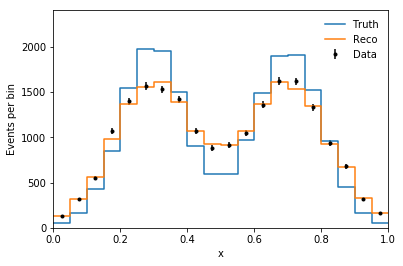

In [18]:
truth_hist, be = np.histogram(truth, bins=extended_bins)
reco_hist, be = np.histogram(reco, bins=be)

np.random.seed(0)
data = np.random.poisson(reco_hist)

plot_hist(truth_hist, bins, label='Truth')
plot_hist(reco_hist, bins, label='Reco')
plt.errorbar(bin_centers, data[1:-1], yerr=np.sqrt(data[1:-1]), fmt='.k', label='Data')
plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel('Events per bin')
plt.ylim(0, 2400)
plt.show()

In [19]:
def response_matrix(truth, reco, bins):
    unnormalised_response_matrix = np.histogram2d(reco, truth, bins=bins)[0]
    norm = unnormalised_response_matrix.sum(axis=0, keepdims=True)
    return unnormalised_response_matrix / norm

R = response_matrix(truth, reco, extended_bins)

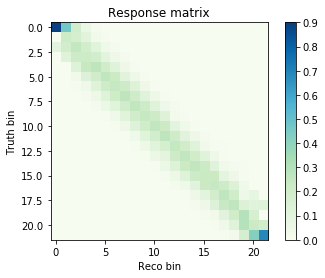

In [20]:
plt.imshow(R, cmap='GnBu')
plt.colorbar()
plt.title('Response matrix')
plt.xlabel('Reco bin')
plt.ylabel('Truth bin')
plt.show()

In [25]:
from scipy.linalg import cho_factor, cho_solve

def SqExpKernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

def GaussianKernel(a, b, params):
    mu, w = params
    sep = (a-mu)**2 + (b.T-mu)**2
    return np.exp(-sep/(2*w))

def ConvKernel(a, b, params):
    l, mu, w = params
    k1 = SqExpKernel(a, b, l)
    k2 = GaussianKernel(a, b, (mu, w))
    return k1*k2

Xtrain = np.append(-bin_centers[0], bin_centers)
Xtrain = np.append(Xtrain, bin_centers[-1] + bin_centers[0]*2).reshape(-1, 1)
Xtest = np.linspace(Xtrain[0], Xtrain[-1], 200).reshape(-1, 1)

def GP_predict(params):
    t = np.dot(np.linalg.inv(R), data)
    kernel = ConvKernel
    
    K = kernel(Xtrain, Xtrain, params)
    Ks = kernel(Xtest, Xtrain, params)
    Kss = kernel(Xtest, Xtest, params)
    
    L = cho_factor(K + 2.5e-10*np.eye(len(Xtrain)))
    alpha = cho_solve(L, t)
    mu = np.dot(Ks, alpha)
    
    cov = Kss - np.dot(Ks, cho_solve(L, Ks.T))
    return mu, cov

params = (.5, 0.5, 0.04)
mu, cov = GP_predict(params)
std = np.sqrt(np.diag(cov))

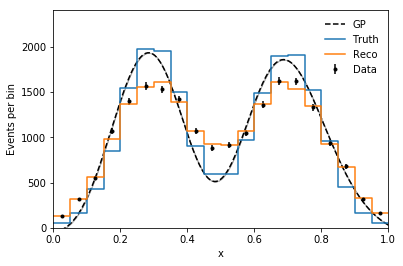

In [26]:
plt.plot(Xtest, mu, '--k', label='GP')
plt.errorbar(bin_centers, data[1:-1], yerr=np.sqrt(data[1:-1]), fmt='.k', label='Data')
plt.fill_between(Xtest.flatten(), mu+std, mu+-std, color='k', alpha=0.3)
plot_hist(truth_hist, bins, label='Truth')
plot_hist(reco_hist, bins, color='C1', label='Reco')
plt.legend(frameon=False)
plt.ylim(0, 2400)
plt.ylabel('Events per bin')
plt.xlabel('x')
plt.show()